# The Simpsons

## Preparations

### Import libraries

- Tensorflow: Machine Learning Library
- Matplotlib: Plotting (math) library

In [51]:
import tensorflow as tf
from matplotlib import image
from tensorflow.keras import datasets, layers, models, Sequential
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import itertools
import glob
from sklearn import preprocessing, metrics

In [52]:
import warnings

#warnings.filterwarnings('ignore')

### Select Characters

Create a list of characters that we want to recognise

In [53]:
characters = [
    # "abraham_grampa_simpson", not same images
    # "agnes_skinner", only ~50 images
    "apu_nahasapeemapetilon",
    # "barney_gumble", only ~100 images
    "bart_simpson",
    # "carl_carlson", only ~100 images
    "charles_montgomery_burns",
    "chief_wiggum",
    # "cletus_spuckler", only ~50 images
    # "comic_book_guy", great confusion
    # "disco_stu", only 8 (!) images
    "edna_krabappel",
    # "fat_tony", only ~30 images
    # "gil", only ~30 images
    #"groundskeeper_willie", only ~120 images
    "homer_simpson",
    "kent_brockman",
    "krusty_the_clown",
    # "lenny_leonard", great confusion
    # "lionel_hutz", only 3 (!!!) images
    "lisa_simpson",
    # "maggie_simpson", only ~120 images
    "marge_simpson",
    # "martin_prince", only ~120 images
    # "mayor_quimby", only ~250 images
    "milhouse_van_houten",
    # "miss_hoover", only ~20 images
    "moe_szyslak",
    "ned_flanders",
    # "nelson_muntz", great confusion
    # "otto_mann", only ~30 images
    # "patty_bouvier", only ~70 images
    "principal_skinner",
    # "professor_john_frink", only ~70 images
    # "rainier_wolfcastle", only ~50 images
    # "ralph_wiggum", only ~90 images
    # "selma_bouvier", only ~100 images
    "sideshow_bob",
    # "sideshow_mel", only ~40 images
    # "snake_jailbird", only ~50 images
    # "troy_mcclure", only 8 (!) images
    # "waylon_smithers", only ~180 images
]

In [54]:
#Randomly pick characters for testing
import random

number_of_characters = len(characters)

selected_characters = random.sample(characters, number_of_characters)
print(selected_characters)

['marge_simpson', 'sideshow_bob', 'homer_simpson', 'lisa_simpson', 'milhouse_van_houten', 'bart_simpson', 'principal_skinner', 'moe_szyslak', 'kent_brockman', 'ned_flanders', 'chief_wiggum', 'krusty_the_clown', 'charles_montgomery_burns', 'apu_nahasapeemapetilon', 'edna_krabappel']


## Labeling for CNN

In [55]:
encoded_labels = preprocessing.LabelEncoder()
encoded_labels.fit(selected_characters)  # assign every character an unique id

LabelEncoder()

### Directories

In [56]:
directories = {
    "data_directory": "./data/archive/",
}

directories["annotation_file"] = directories["data_directory"] + "annotation.txt"
directories["dataset"] = directories["data_directory"] + "simpsons_dataset/"
directories["testset"] = directories["data_directory"] + "kaggle_simpson_testset/kaggle_simpson_testset/"

## Previewing the characters

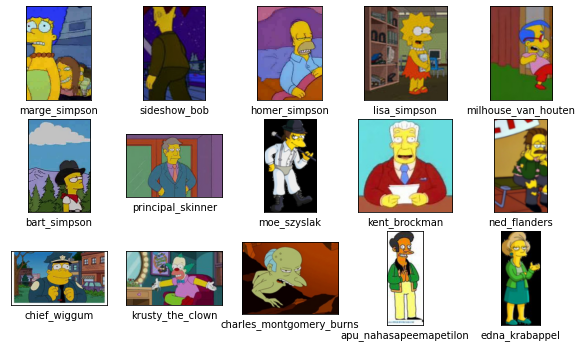

In [57]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = image.imread(directories["dataset"] + character_name + "/pic_0000.jpg")
    plt.imshow(img)
    plt.xlabel(character_name)
plt.show()

## Resizing Images
For testing this code creates the same as above but resized to the standard_resolution variable

In [58]:
standard_resolution = 352
resampling_algorithm = Image.LANCZOS  # todo decide on resampling algorithm

In [59]:
def get_resized_image(image_path):
    img = Image.open(image_path)
    img = img.resize(size=(standard_resolution, standard_resolution),
                     resample=resampling_algorithm)
    img = np.asarray(img)  #store im as numpy array
    # shape of image is ([128x(r,g,b)], [128x(r,g,b)]), for each row and each column
    img = np.array(img)
    return img

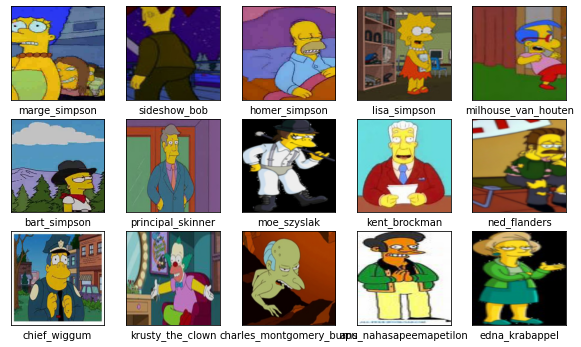

In [60]:
plt.figure(figsize=(10, 10))
for iterator, character_name in enumerate(selected_characters):
    plt.subplot(5, 5, iterator + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(get_resized_image(directories["dataset"] + character_name + "/pic_0000.jpg"))
    plt.xlabel(character_name)
plt.show()

## Load files and split into test data

In [61]:
test_factor = 0.17  # determine what percentage of each character's images should be used for testing

In [62]:
print(selected_characters)

['marge_simpson', 'sideshow_bob', 'homer_simpson', 'lisa_simpson', 'milhouse_van_houten', 'bart_simpson', 'principal_skinner', 'moe_szyslak', 'kent_brockman', 'ned_flanders', 'chief_wiggum', 'krusty_the_clown', 'charles_montgomery_burns', 'apu_nahasapeemapetilon', 'edna_krabappel']


In [63]:
training_images = []  # the images as rgb values
training_labels = []  # the corresponding character name

test_images = []  # the test images as rgb values
test_labels = []  # the corresponding character name

for character_name in selected_characters:  # loop over all selected characters

    current_character_path = directories["dataset"] + character_name + "/"
    current_character_paths_list = glob.glob(current_character_path + "*.jpg")

    # calculate how many files are test data and how many files are training data
    current_character_picture_count = len(current_character_paths_list)
    current_character_training_count = round(current_character_picture_count * (1 - test_factor))
    current_image_position = 0
    current_breakpoint = current_character_picture_count * test_factor

    encoded_character_label = encoded_labels.transform([character_name])
    print("Loading Character:" + character_name + " (label number " + str(encoded_character_label[0]) + ")")
    print("", end='\n')

    for current_image_position, current_character_picture_path in enumerate(
            current_character_paths_list):  # loop over all files ending in .jpg in the current folder
        print("[", current_image_position + 1, "/", current_character_picture_count,
              "]" + current_character_picture_path,
              end='\r')

        current_character_picture = get_resized_image(current_character_picture_path)  # load current picture
        rand_int = random.randint(1,
                                  current_character_picture_count)  # random factor to decide if picture is training or test data
        if rand_int <= current_breakpoint:
            test_images.append(current_character_picture)
            test_labels.append(encoded_character_label)
        else:
            training_images.append(current_character_picture)
            training_labels.append(encoded_character_label)
    print("", end='\n')

training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)
test_images = np.array(test_images)

Loading Character:marge_simpson (label number 9)

[ 1290 / 1291 ]./data/archive/simpsons_dataset/marge_simpson/pic_0743.jpg
Loading Character:sideshow_bob (label number 14)

877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0771.jpg[ 57 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0573.jpg[ 100 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0760.jpg[ 103 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0576.jpg[ 140 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0211.jpg[ 145 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0775.jpg[ 180 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0428.jpg[ 213 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0659.jpg[ 247 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0706.jpg[ 296 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0065.jpg[ 348 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_0264.jpg[ 398 / 877 ]./data/archive/simpsons_dataset/sideshow_bob/pic_052

In [64]:
print(training_images[0].shape)
print(len(training_images))
print(len(test_images))

2899

## Create Convolutional Neuronal Network

In [65]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(standard_resolution, standard_resolution, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(selected_characters), activation='relu')
])

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 352, 352, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 352, 352, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 352, 352, 8)       224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 176, 176, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 176, 176, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 88, 88, 16)       0         
 2D)                                                  

In [68]:
#training_images, test_images = training_images / 255.0, test_images / 255.0

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # SparseCategoricalCrossentropy uses numbered labels instead of hot encoding (https://towardsdatascience.com/building-a-one-hot-encoding-layer-with-tensorflow-f907d686bf39)
    metrics=['accuracy']
)

history = model.fit(
    training_images, training_labels,
    epochs=30,
    validation_data=(test_images, test_labels)
)

Epoch 1/30
449/449 [==============================] - 230s 506ms/step - loss: 2.4307 - accuracy: 0.2209 - val_loss: 2.1465 - val_accuracy: 0.3301
Epoch 2/30
449/449 [==============================] - 222s 494ms/step - loss: 2.0311 - accuracy: 0.3796 - val_loss: 1.9397 - val_accuracy: 0.4070
Epoch 3/30
449/449 [==============================] - 227s 505ms/step - loss: 1.7710 - accuracy: 0.4787 - val_loss: 1.7005 - val_accuracy: 0.4978
Epoch 4/30
449/449 [==============================] - 217s 483ms/step - loss: 1.5638 - accuracy: 0.5335 - val_loss: 1.5940 - val_accuracy: 0.5222
Epoch 5/30
449/449 [==============================] - 213s 474ms/step - loss: 1.3959 - accuracy: 0.5879 - val_loss: 1.4195 - val_accuracy: 0.5830
Epoch 6/30
449/449 [==============================] - 212s 472ms/step - loss: 1.1719 - accuracy: 0.6610 - val_loss: 1.2356 - val_accuracy: 0.6475
Epoch 7/30
449/449 [==============================] - 212s 472ms/step - loss: 0.9878 - accuracy: 0.7131 - val_loss: 1.1203 -

## Export model

In [69]:
model.save_weights('./models/simpsons')

## Visualise the Network

91/91 - 9s - loss: 0.8543 - accuracy: 0.8261 - 9s/epoch - 104ms/step


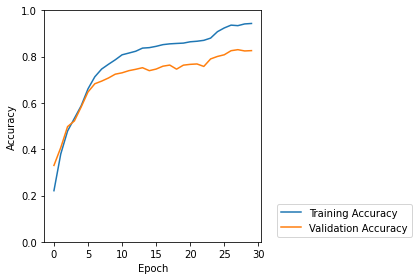

In [70]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("accuracy.png", dpi=300)
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

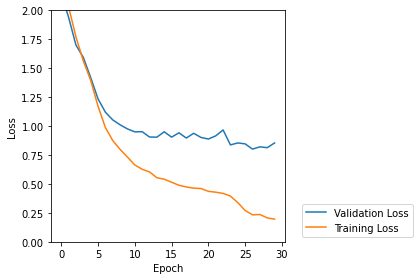

In [71]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0))
plt.tight_layout()
plt.savefig("loss.png", dpi=300)

## Load the test dataset

In [72]:
def load_test_set():
    pics, labels = [], []
    for all_test_pictures in glob.glob(directories["testset"] + '*.jpg'):
        file_name = all_test_pictures.split("/")[
            -1]  # './data/archive/kaggle_simpson_testset/kaggle_simpson_testset/principal_skinner_34.jpg'
        character_name_with_number = file_name.split(".jpg")[-2]  # 'principal_skinner_34'
        character_name_clean = character_name_with_number.rsplit('_', 1)[0]  # 'principal_skinner'

        if character_name_clean in selected_characters:
            character_label = encoded_labels.transform([character_name_clean])
            temp = get_resized_image(all_test_pictures)
            pics.append(temp)
            labels.append(character_label)
    x_test = np.array(pics)
    y_test = np.array(labels)
    print("Test set", x_test.shape, y_test.shape)
    return x_test, y_test

In [73]:
x_test, y_test = load_test_set()
prediction = model.predict(x_test)

Test set (743, 352, 352, 3) (743, 1)


## Confusion Matrix

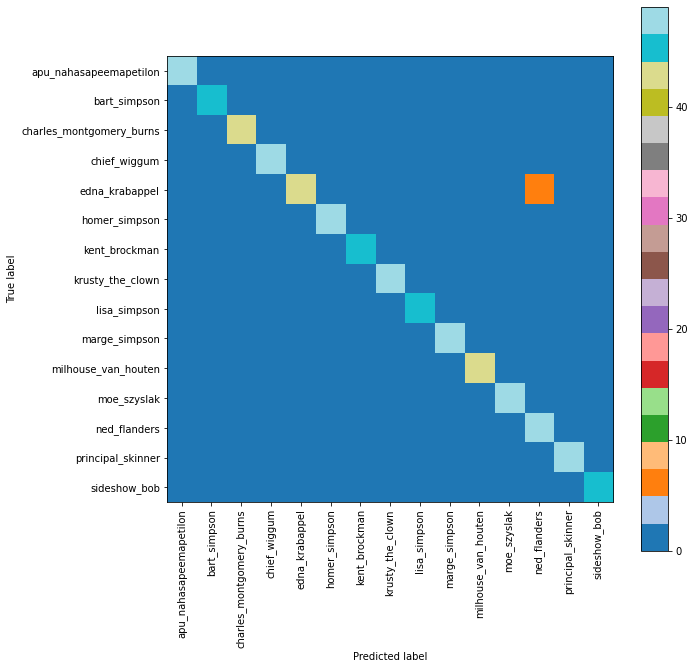

In [74]:
plt.figure(figsize=(10, 10))
labels = list(encoded_labels.classes_)
cm = metrics.confusion_matrix(y_test, np.argmax(prediction, axis=1))
tick_marks = np.arange(len(labels))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.tab20)
plt.colorbar()
_ = plt.xticks(tick_marks, labels, rotation=90)
_ = plt.yticks(tick_marks, labels)
plt.savefig("confusion_matrix.png", dpi=300)

## Simple Predictions

In [75]:
prediction_images = []

random_choice = random.choice(selected_characters)
random_number = random.randint(0, 30)

current_character_picture = get_resized_image(
    directories["testset"] + random_choice + "_" + str(random_number) + ".jpg")

img_array = tf.expand_dims(current_character_picture,
                           0)  # Create a batch of images, because a single image can not be processed

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("Randomly chosen character: " + random_choice)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(encoded_labels.inverse_transform([np.argmax(score)])[0], 100 * np.max(score))
) # re-encode the label to a character name

Randomly chosen character: homer_simpson
This image most likely belongs to homer_simpson with a 99.98 percent confidence.
